# Kavin Singhakhet - 6310422040

## **Importing libraries and datasets**

In [77]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
import statistics

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
import xgboost as xgb

from sklearn.metrics import precision_score, recall_score, f1_score, auc, roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve
from xgboost import plot_importance


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
# Import data

df_response = pd.read_csv('/content/drive/MyDrive/NIDA/CRM/Campaign Response Model/Retail_Data_Response.csv')
df_transactions = pd.read_csv('/content/drive/MyDrive/NIDA/CRM/Campaign Response Model/Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [60]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [61]:
df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [62]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


## **Data Preparation**

In [90]:
campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions['tran_amount1'] = df_transactions['tran_amount']
df_transactions['tran_amount2'] = df_transactions['tran_amount']
df_transactions['tran_amount3'] = df_transactions['tran_amount']
df_transactions.head()

,customer_id,trans_date,tran_amount,recent,tran_amount1,tran_amount2,tran_amount3
0,CS5295,2013-02-11,35,764.0,35,35,35
1,CS4768,2015-03-15,39,2.0,39,39,39
2,CS2122,2013-02-26,52,749.0,52,52,52
3,CS1217,2011-11-16,99,1217.0,99,99,99
4,CS1850,2013-11-20,78,482.0,78,78,78


In [93]:
## create data set with CLV variables

df_clv = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                    
                                                     'customer_id': lambda x: len(x),                 
                                                     'tran_amount': lambda x: x.sum(),                       
                                                     'trans_date': lambda x: (x.max() - x.min()).days,
                                                     'tran_amount1': lambda x: statistics.stdev(x),
                                                     'tran_amount2': lambda x: max(x),
                                                     'tran_amount3': lambda x: min(x)})       

df_clv.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value',
                       'trans_date' : 'AOU',
                       'tran_amount1': 'SD',
                       'tran_amount2': 'max_spend',
                       'tran_amount3': 'min_spend'}, inplace=True)

df_clv['ticket_size'] = df_clv['monetary_value'] / df_clv['frequency']

In [94]:
df_clv = df_clv.reset_index()
df_clv.head()

,customer_id,recency,frequency,monetary_value,AOU,SD,max_spend,min_spend,ticket_size
0,CS1112,62.0,15,1012,1309,19.766012,105,36,67.466667
1,CS1113,36.0,20,1490,1354,21.254102,98,36,74.500000
2,CS1114,33.0,19,1432,1309,21.341692,105,37,75.368421
3,CS1115,12.0,22,1659,1303,18.151896,104,41,75.409091
4,CS1116,204.0,13,857,1155,22.940000,105,40,65.923077


## **Calculating response rate**

In [95]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


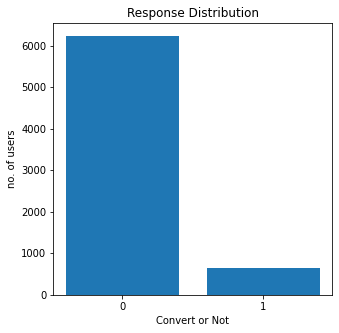

In [96]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

In [97]:
## merging two data sets - CLV

df_modeling_clv = pd.merge(df_response,df_clv)
df_modeling_clv.head()

,customer_id,response,recency,frequency,monetary_value,AOU,SD,max_spend,min_spend,ticket_size
0,CS1112,0,62.0,15,1012,1309,19.766012,105,36,67.466667
1,CS1113,0,36.0,20,1490,1354,21.254102,98,36,74.500000
2,CS1114,1,33.0,19,1432,1309,21.341692,105,37,75.368421
3,CS1115,1,12.0,22,1659,1303,18.151896,104,41,75.409091
4,CS1116,1,204.0,13,857,1155,22.940000,105,40,65.923077


## **Creating train and test dataset**

In [103]:
##  spliting dataframe into X and y

X_clv = df_modeling_clv.drop(columns=['response','customer_id'])
y_clv = df_modeling_clv['response']

In [104]:
## creating train and test dataset

X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.2, random_state=21)

## **Fixing imbalanced with SMOTE**

In [105]:
sm = SMOTE(random_state=0)

sm.fit(X_train_clv, y_train_clv)
X_SMOTE_clv, y_SMOTE_clv = sm.fit_sample(X_train_clv, y_train_clv)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## **XGBoost**

In [106]:
print('XGBoost model - SMOTE CLV')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=2,
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_SMOTE_clv = xgb_model.fit(X_SMOTE_clv, y_SMOTE_clv, early_stopping_rounds=5, eval_set=[(X_test_clv.to_numpy(), y_test_clv)])
predictions =  xgb_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_clv.predict(X_test_clv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE CLV
[0]	validation_0-auc:0.660398
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.676319
[2]	validation_0-auc:0.694683
[3]	validation_0-auc:0.694683
[4]	validation_0-auc:0.694683
[5]	validation_0-auc:0.701896
[6]	validation_0-auc:0.707952
[7]	validation_0-auc:0.70356
[8]	validation_0-auc:0.707326
[9]	validation_0-auc:0.714671
[10]	validation_0-auc:0.71603
[11]	validation_0-auc:0.716733
[12]	validation_0-auc:0.717323
[13]	validation_0-auc:0.72373
[14]	validation_0-auc:0.724818
[15]	validation_0-auc:0.721496
[16]	validation_0-auc:0.71726
[17]	validation_0-auc:0.715888
[18]	validation_0-auc:0.714794
[19]	validation_0-auc:0.71252
Stopping. Best iteration:
[14]	validation_0-auc:0.724818

training set
              precision    recall  f1-score   support

           0       0.77      0.53      0.63      4980
           1       0.64      0.84      0.73      4980

    accuracy                           0.69      9960
   macro avg     

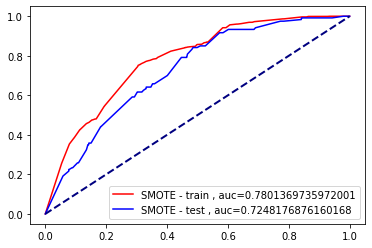

In [108]:
## AUC XGBoost

y_score_train = xgb_model_SMOTE_clv.predict_proba(X_SMOTE_clv)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE_clv, y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE_clv, y_score_train[:,1])
plt.plot(fpr_train, tpr_train, color='red', label=f'SMOTE - train , auc={auc_train}')

y_score_test = xgb_model_SMOTE_clv.predict_proba(X_test_clv.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test_clv, y_score_test[:,1])
auc_test = roc_auc_score(y_test_clv, y_score_test[:,1])
plt.plot(fpr_test, tpr_test, color='blue', label=f'SMOTE - test , auc={auc_test}')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [109]:
## building pipeline for hyperparameter tuning

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

# Create a pipeline
pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=9))
])

In [128]:
## hyper parameter tuning - grid search

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
# Define our search space for grid search
search_space = [
  {
    'clf__n_estimators': [100, 1000],
    'clf__learning_rate': [0.01, 0.2],
    'clf__max_depth': range(2, 4),
    'clf__colsample_bytree': [i/10.0 for i in range(4, 7)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [chi2],
    'fs__k': [2],
  }
]
# Define cross validation
kfold = KFold(n_splits=10, random_state=42)
# AUC and F1 as score
scoring = {'AUC':'roc_auc','F1 score': 'f1_micro'}
# Define grid search
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

# Fit grid search

xgb_model_clv_GS = grid.fit(X_train_clv, y_train_clv)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  6.9min finished


In [134]:
predicted_y = []
expected_y = []
predictions = xgb_model_clv_GS.predict(X_test_clv)
print('Best AUC Score: {}'.format(xgb_model_clv_GS.best_score_))
print(confusion_matrix(y_test_clv,predictions))


predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

Best AUC Score: 0.7130751577363472
[[651 606]
 [ 19 101]]
test set
              precision    recall  f1-score   support

           0       0.97      0.52      0.68      1257
           1       0.14      0.84      0.24       120

    accuracy                           0.55      1377
   macro avg       0.56      0.68      0.46      1377
weighted avg       0.90      0.55      0.64      1377



In [135]:
print(xgb_model_clv_GS.best_params_)

{'clf__colsample_bytree': 0.4, 'clf__gamma': 0.0, 'clf__learning_rate': 0.01, 'clf__max_depth': 2, 'clf__n_estimators': 100, 'fs__k': 2, 'fs__score_func': <function chi2 at 0x7f968badf3b0>}


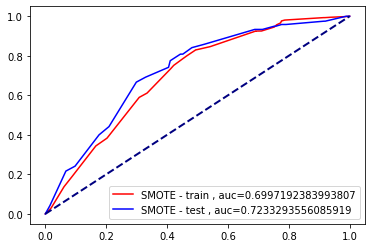

In [136]:
## AUC

y_score_train = xgb_model_clv_GS.predict_proba(X_SMOTE_clv)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE_clv, y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE_clv, y_score_train[:,1])
plt.plot(fpr_train, tpr_train, color='red', label=f'SMOTE - train , auc={auc_train}')

y_score_test = xgb_model_clv_GS.predict_proba(X_test_clv.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test_clv, y_score_test[:,1])
auc_test = roc_auc_score(y_test_clv, y_score_test[:,1])
plt.plot(fpr_test, tpr_test, color='blue', label=f'SMOTE - test , auc={auc_test}')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

## **MLPClassifier**

In [118]:
print('MLPClassifier model - SMOTE CLV')

clf = MLPClassifier(random_state=1, max_iter=300)

predicted_y = []
expected_y = []

mlp_model_SMOTE_clv = clf.fit(X_SMOTE_clv, y_SMOTE_clv)
predictions =  mlp_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = mlp_model_SMOTE_clv.predict(X_test_clv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

MLPClassifier model - SMOTE CLV
training set
              precision    recall  f1-score   support

           0       0.92      0.30      0.45      4980
           1       0.58      0.97      0.73      4980

    accuracy                           0.64      9960
   macro avg       0.75      0.64      0.59      9960
weighted avg       0.75      0.64      0.59      9960

test set
              precision    recall  f1-score   support

           0       0.99      0.32      0.49      1257
           1       0.12      0.96      0.21       120

    accuracy                           0.38      1377
   macro avg       0.55      0.64      0.35      1377
weighted avg       0.91      0.38      0.46      1377



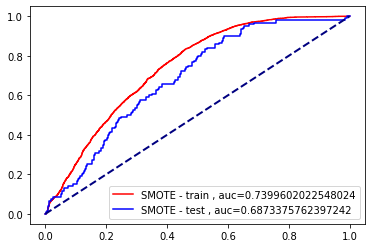

In [119]:
## AUC MLPClassifier

y_score_train = mlp_model_SMOTE_clv.predict_proba(X_SMOTE_clv)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE_clv, y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE_clv, y_score_train[:,1])
plt.plot(fpr_train, tpr_train, color='red', label=f'SMOTE - train , auc={auc_train}')

y_score_test = mlp_model_SMOTE_clv.predict_proba(X_test_clv.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test_clv, y_score_test[:,1])
auc_test = roc_auc_score(y_test_clv, y_score_test[:,1])
plt.plot(fpr_test, tpr_test, color='blue', label=f'SMOTE - test , auc={auc_test}')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

## **SVM**

In [122]:
from sklearn import svm

print('SVM model - SMOTE CLV')

clf = svm.SVC(probability=True, )

predicted_y = []
expected_y = []

svm_model_SMOTE_clv = clf.fit(X_SMOTE_clv, y_SMOTE_clv)
predictions =  svm_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = svm_model_SMOTE_clv.predict(X_test_clv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

SVM model - SMOTE CLV
training set
              precision    recall  f1-score   support

           0       0.74      0.51      0.60      4980
           1       0.62      0.82      0.71      4980

    accuracy                           0.66      9960
   macro avg       0.68      0.66      0.66      9960
weighted avg       0.68      0.66      0.66      9960

test set
              precision    recall  f1-score   support

           0       0.97      0.52      0.68      1257
           1       0.15      0.85      0.25       120

    accuracy                           0.55      1377
   macro avg       0.56      0.69      0.46      1377
weighted avg       0.90      0.55      0.64      1377



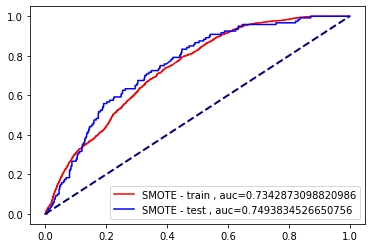

In [123]:
## AUC SVM

y_score_train = svm_model_SMOTE_clv.predict_proba(X_SMOTE_clv)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE_clv, y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE_clv, y_score_train[:,1])
plt.plot(fpr_train, tpr_train, color='red', label=f'SMOTE - train , auc={auc_train}')

y_score_test = svm_model_SMOTE_clv.predict_proba(X_test_clv.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test_clv, y_score_test[:,1])
auc_test = roc_auc_score(y_test_clv, y_score_test[:,1])
plt.plot(fpr_test, tpr_test, color='blue', label=f'SMOTE - test , auc={auc_test}')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

## **AdaBoostClassifier**

In [126]:
from sklearn.ensemble import AdaBoostClassifier

print('SVM model - SMOTE CLV')

clf = AdaBoostClassifier(n_estimators=100, random_state=0)

predicted_y = []
expected_y = []

ada_model_SMOTE_clv = clf.fit(X_SMOTE_clv, y_SMOTE_clv)
predictions =  ada_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = ada_model_SMOTE_clv.predict(X_test_clv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

SVM model - SMOTE CLV
training set
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      4980
           1       0.87      0.82      0.84      4980

    accuracy                           0.85      9960
   macro avg       0.85      0.85      0.85      9960
weighted avg       0.85      0.85      0.85      9960

test set
              precision    recall  f1-score   support

           0       0.93      0.86      0.89      1257
           1       0.16      0.28      0.20       120

    accuracy                           0.81      1377
   macro avg       0.54      0.57      0.55      1377
weighted avg       0.86      0.81      0.83      1377



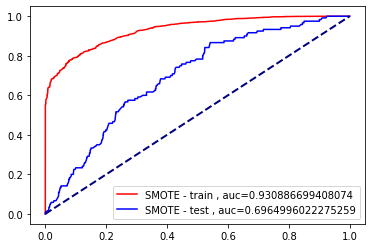

In [127]:
## AUC ADA

y_score_train = ada_model_SMOTE_clv.predict_proba(X_SMOTE_clv)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE_clv, y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE_clv, y_score_train[:,1])
plt.plot(fpr_train, tpr_train, color='red', label=f'SMOTE - train , auc={auc_train}')

y_score_test = ada_model_SMOTE_clv.predict_proba(X_test_clv.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test_clv, y_score_test[:,1])
auc_test = roc_auc_score(y_test_clv, y_score_test[:,1])
plt.plot(fpr_test, tpr_test, color='blue', label=f'SMOTE - test , auc={auc_test}')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

## **RandomForestClassifier**

In [180]:
print('RandomForestClassifier model - SMOTE CLV')

clf = RandomForestClassifier(max_depth=2, random_state=8, max_samples=150)
predicted_y = []
expected_y = []

rf_model_SMOTE_clv = clf.fit(X_SMOTE_clv, y_SMOTE_clv)
predictions =  rf_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = rf_model_SMOTE_clv.predict(X_test_clv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

RandomForestClassifier model - SMOTE CLV
training set
              precision    recall  f1-score   support

           0       0.75      0.57      0.64      4980
           1       0.65      0.81      0.72      4980

    accuracy                           0.69      9960
   macro avg       0.70      0.69      0.68      9960
weighted avg       0.70      0.69      0.68      9960

test set
              precision    recall  f1-score   support

           0       0.97      0.58      0.73      1257
           1       0.15      0.79      0.26       120

    accuracy                           0.60      1377
   macro avg       0.56      0.69      0.49      1377
weighted avg       0.90      0.60      0.69      1377



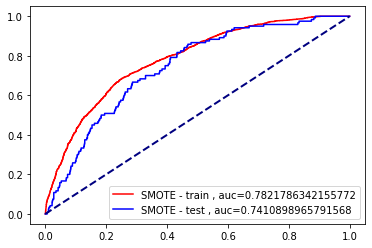

In [181]:
## AUC RandomForestClassifier

y_score_train = rf_model_SMOTE_clv.predict_proba(X_SMOTE_clv)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE_clv, y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE_clv, y_score_train[:,1])
plt.plot(fpr_train, tpr_train, color='red', label=f'SMOTE - train , auc={auc_train}')

y_score_test = rf_model_SMOTE_clv.predict_proba(X_test_clv.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test_clv, y_score_test[:,1])
auc_test = roc_auc_score(y_test_clv, y_score_test[:,1])
plt.plot(fpr_test, tpr_test, color='blue', label=f'SMOTE - test , auc={auc_test}')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

#### SVM have best performance

*   AUC - train = 0.734
*   AUC - test = 0.749
